<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Генерация-данных-и-функции" data-toc-modified-id="Генерация-данных-и-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Генерация данных и функции</a></span></li><li><span><a href="#Генерация-данных-и-проверка-кода" data-toc-modified-id="Генерация-данных-и-проверка-кода-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Генерация данных и проверка кода</a></span></li><li><span><a href="#Задача-регрессии" data-toc-modified-id="Задача-регрессии-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Задача регрессии</a></span></li></ul></div>

In [1]:
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

### Генерация данных и функции

In [39]:
# 1.1. класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [48]:
# 1.2. Класс терминального узла
class Leaf:
    
    def __init__(self, data, labels, reg):
        self.data = data
        self.labels = labels
        self.reg = reg
        self.prediction = self.predict()
        
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0 # генерация ключей словаря и счетчик
            classes[label] += 1
        if self.reg: # вариант регрессии
            prediction = 0
            for k,v in classes.items():
                w = v / sum(classes.values())
                prediction += k*w
        else:
            prediction = max(classes, key=classes.get)
        
        return prediction   

In [41]:
# 1.3. GINI
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [42]:
# 1.4. Information Gain
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [43]:
# 1.5. Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [44]:
# 1.6. Classification method

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [45]:
# 1.7. Predict function

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [46]:
# 1.8. Main split function -----
def find_best_split(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if min_leaf:
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue
                        
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [51]:
# 1.9. Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf=None, min_quality=None, reg=False):

    quality, t, index = find_best_split(data, labels, min_leaf=min_leaf)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if not min_quality:
        if quality == 0:
            return Leaf(data, labels, reg)
    else:
        if quality < min_quality:
            return Leaf(data, labels, reg)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf=min_leaf)
    false_branch = build_tree(false_data, false_labels, min_leaf=min_leaf)
   
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    
    return Node(index, t, true_branch, false_branch)

In [11]:
# 1.10. tree vizualization

def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    


In [12]:
# 1.11. Accuracy calculation

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [13]:
# 1.12. Viz-function for X-space

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

### Генерация данных и проверка кода

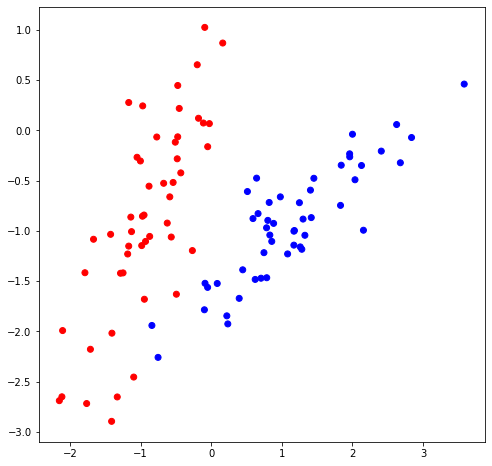

In [49]:
# 2.1. Input DATA

from sklearn import model_selection

classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Индекс 0
        Порог -0.8411814419026544
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


Text(0.5, 1.0, 'Test accuracy=96.67')

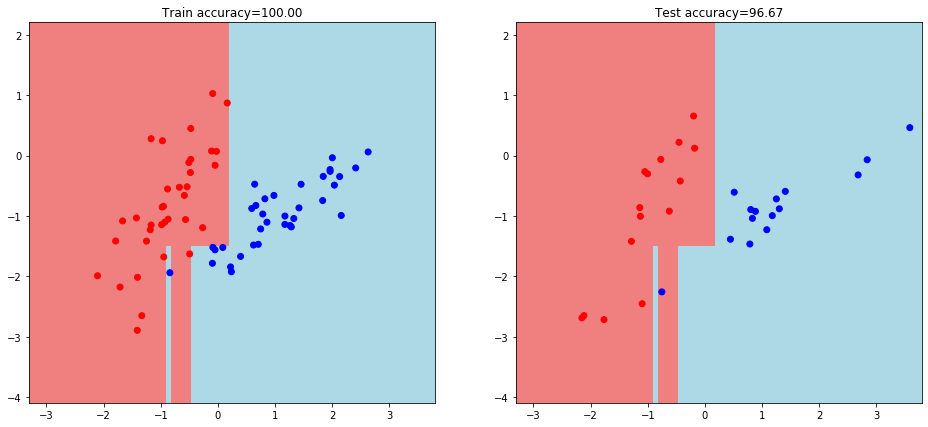

In [52]:
# CASE 1. Без учета всех ограничений 

my_tree_basic = build_tree(train_data, train_labels)
print_tree(my_tree_basic)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree_basic)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree_basic)

train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)

# график обучающей выборки
plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_basic)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [53]:
# CASE 2. Ограничение кол-ва объектов в листе

my_tree_v1 = build_tree(train_data, train_labels, min_leaf=5)

train_answers_v1 = predict(train_data, my_tree_v1)
test_answers_v1 = predict(test_data, my_tree_v1)

train_accuracy = accuracy_metric(train_labels, train_answers_v1)
test_accuracy = accuracy_metric(test_labels, test_answers_v1)

print(train_accuracy, test_accuracy)

98.57142857142858 100.0


50.0 50.0


Text(0.5, 1.0, 'Test accuracy=50.00')

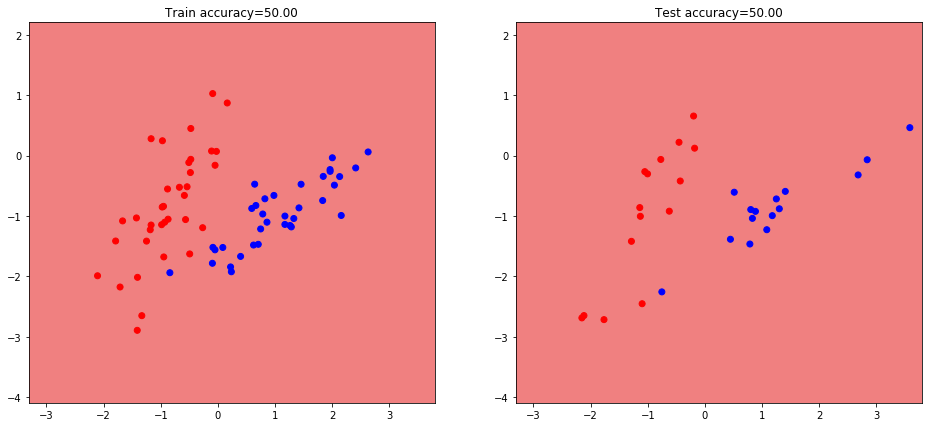

In [54]:
# CASE 3. Information Gain Stop

my_tree_v2 = build_tree(train_data, train_labels, min_quality=0.38)

train_answers_v2 = predict(train_data, my_tree_v2)
test_answers_v2 = predict(test_data, my_tree_v2)

train_accuracy = accuracy_metric(train_labels, train_answers_v2)
test_accuracy = accuracy_metric(test_labels, test_answers_v2)

print(train_accuracy, test_accuracy)

plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_v2)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

### Задача регрессии

In [91]:
# 3.1. Генерация случайных данных

np.random.seed(42)
x1 = np.linspace(-10, 10, 100)
wn1 = np.random.normal(3, 1, 100)
x1 = x1 + wn1

x2 = np.linspace(0, 100, 100)
wn2 = np.random.normal(0, 10, 100)
x2 = x2 + wn2
X = np.array([x1, x2])
y = 0.5*x1 - 0.1*x2

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X.T, y, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 42)

train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((70, 2), (30, 2), (70,), (30,))

In [116]:
# 3.2. Инициализация и обучение дерева решений
from sklearn.metrics import r2_score

my_tree_v3 = build_tree(train_data, train_labels, reg=True, min_quality=0.01, min_leaf=1)

train_answers_v3 = predict(train_data, my_tree_v3)
test_answers_v3 = predict(test_data, my_tree_v3)

print(r2_score(train_labels, train_answers_v3), r2_score(test_labels, test_answers_v3))

1.0 -2.3799974868069387
